In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df=pd.read_csv('amazon_alexa_reviews.csv')

In [3]:
df.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


## Data Visualization

In [4]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [6]:
# Checking for Null Values
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [7]:
# Print value counts for rating, variation, and feedback columns
print('VALUE COUNTS:')
for c in ['rating', 'variation', 'feedback']:
    print(f'\n{c.capitalize()}:')
    print(df[c].value_counts())

VALUE COUNTS:

Rating:
5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64

Variation:
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

Feedback:
1    2893
0     257
Name: feedback, dtype: int64


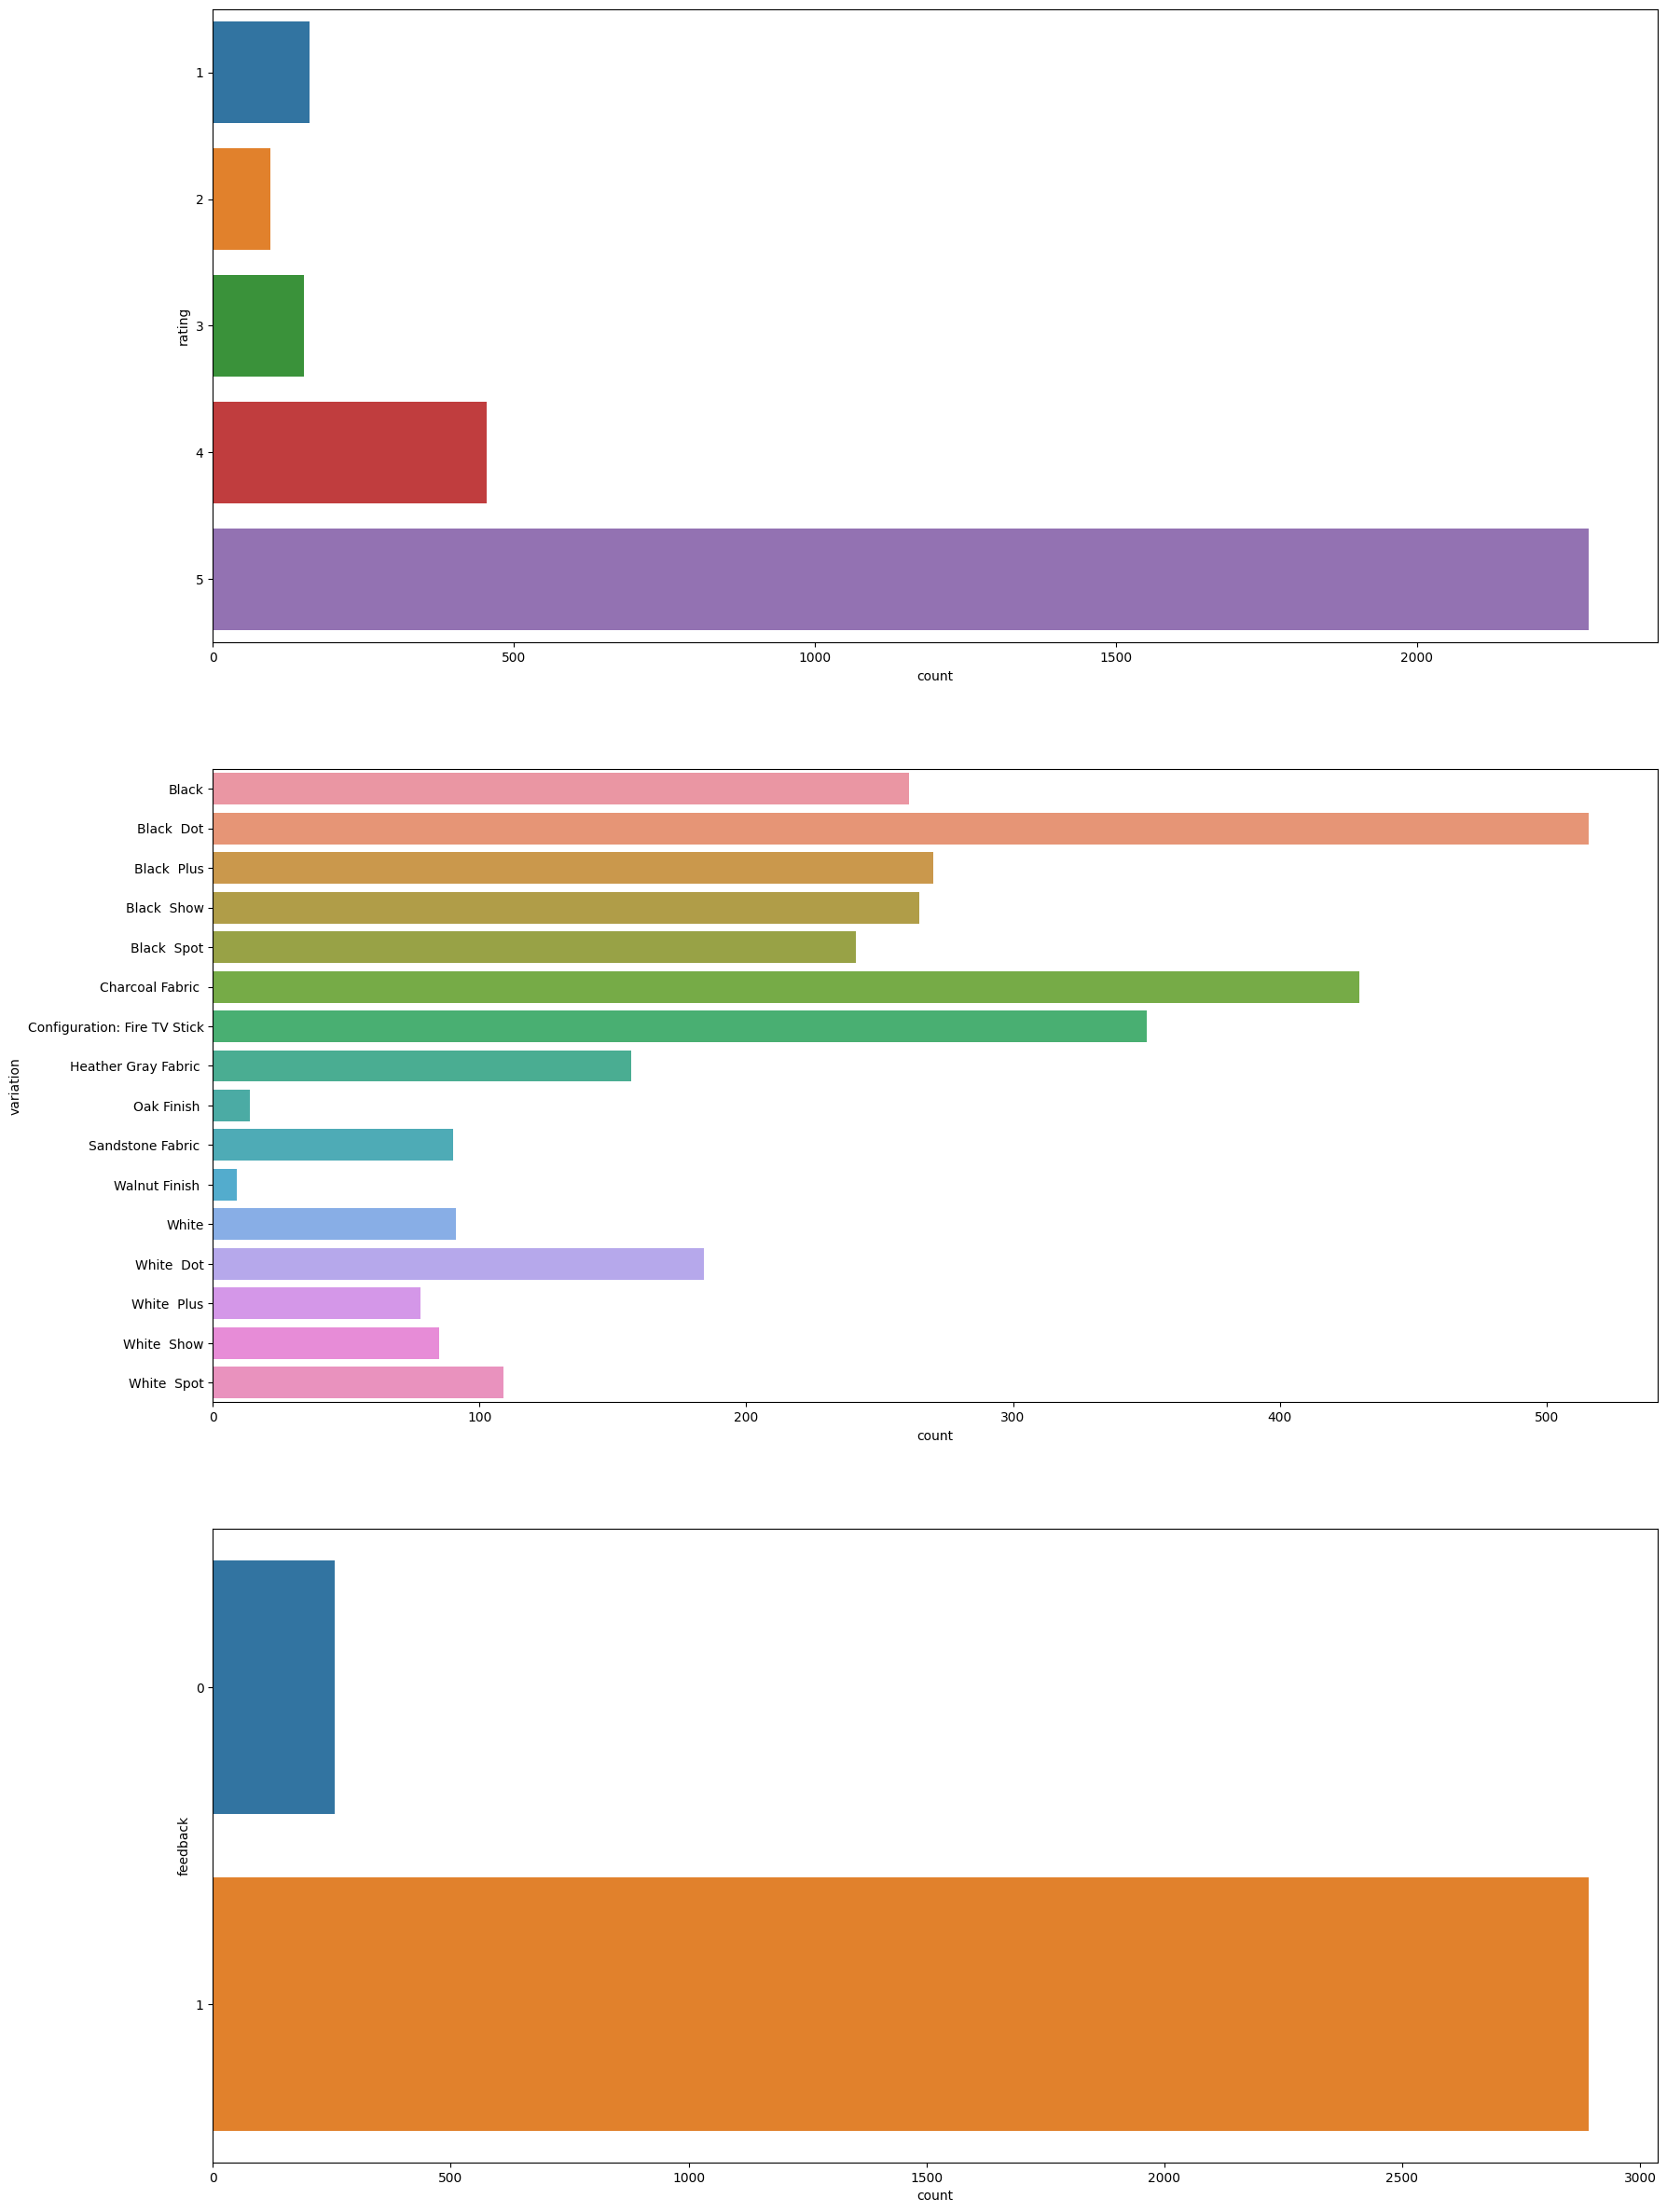

In [8]:
i=1
plt.figure(figsize=(20,30))
for c in ['rating','variation','feedback']:
    plt.subplot(3,1,i)
    sns.countplot(y=df[c].sort_values())
    i+=1

## Data Processing

In [9]:
stopwords = nltk.corpus.stopwords.words('english')

def data_processing(text):
    text=text.lower()
    text=re.sub(r"https\S+www\S+|https\S+",'',text,flags=re.MULTILINE)
    text=re.sub(r'[^\w\s]','',text)
    text_tokens=word_tokenize(text)
    filtered_text=[w for w in text_tokens if w not in stopwords]
    return " ".join(filtered_text)
df['verified_reviews']=df['verified_reviews'].apply(data_processing)
df['verified_reviews']

0                                               love echo
1                                                   loved
2       sometimes playing game answer question correct...
3       lot fun thing 4 yr old learns dinosaurs contro...
4                                                   music
                              ...                        
3145                         perfect kids adults everyone
3146    listening music searching locations checking t...
3147    love things running entire home tv lights ther...
3148    complaint sound quality isnt great mostly use ...
3149                                                 good
Name: verified_reviews, Length: 3150, dtype: object

In [10]:
# Define stemming function and apply to verified_reviews column
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

df['verified_reviews'] = df['verified_reviews'].apply(lambda x: stemming(x))
df['verified_reviews']

0                                               love echo
1                                                   loved
2       sometimes playing game answer question correct...
3       lot fun thing 4 yr old learns dinosaurs contro...
4                                                   music
                              ...                        
3145                         perfect kids adults everyone
3146    listening music searching locations checking t...
3147    love things running entire home tv lights ther...
3148    complaint sound quality isnt great mostly use ...
3149                                                 good
Name: verified_reviews, Length: 3150, dtype: object

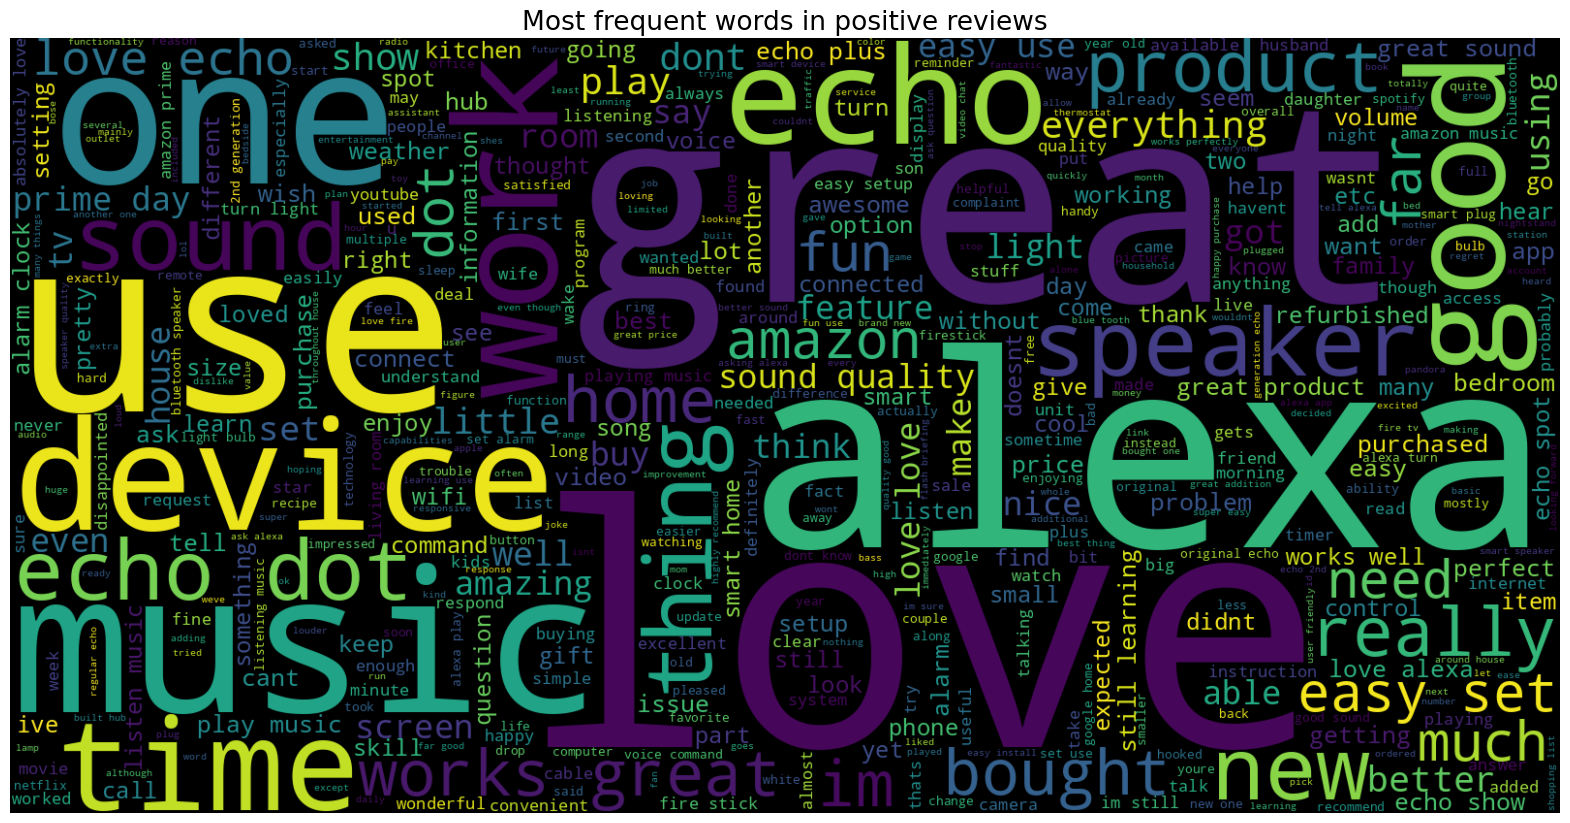

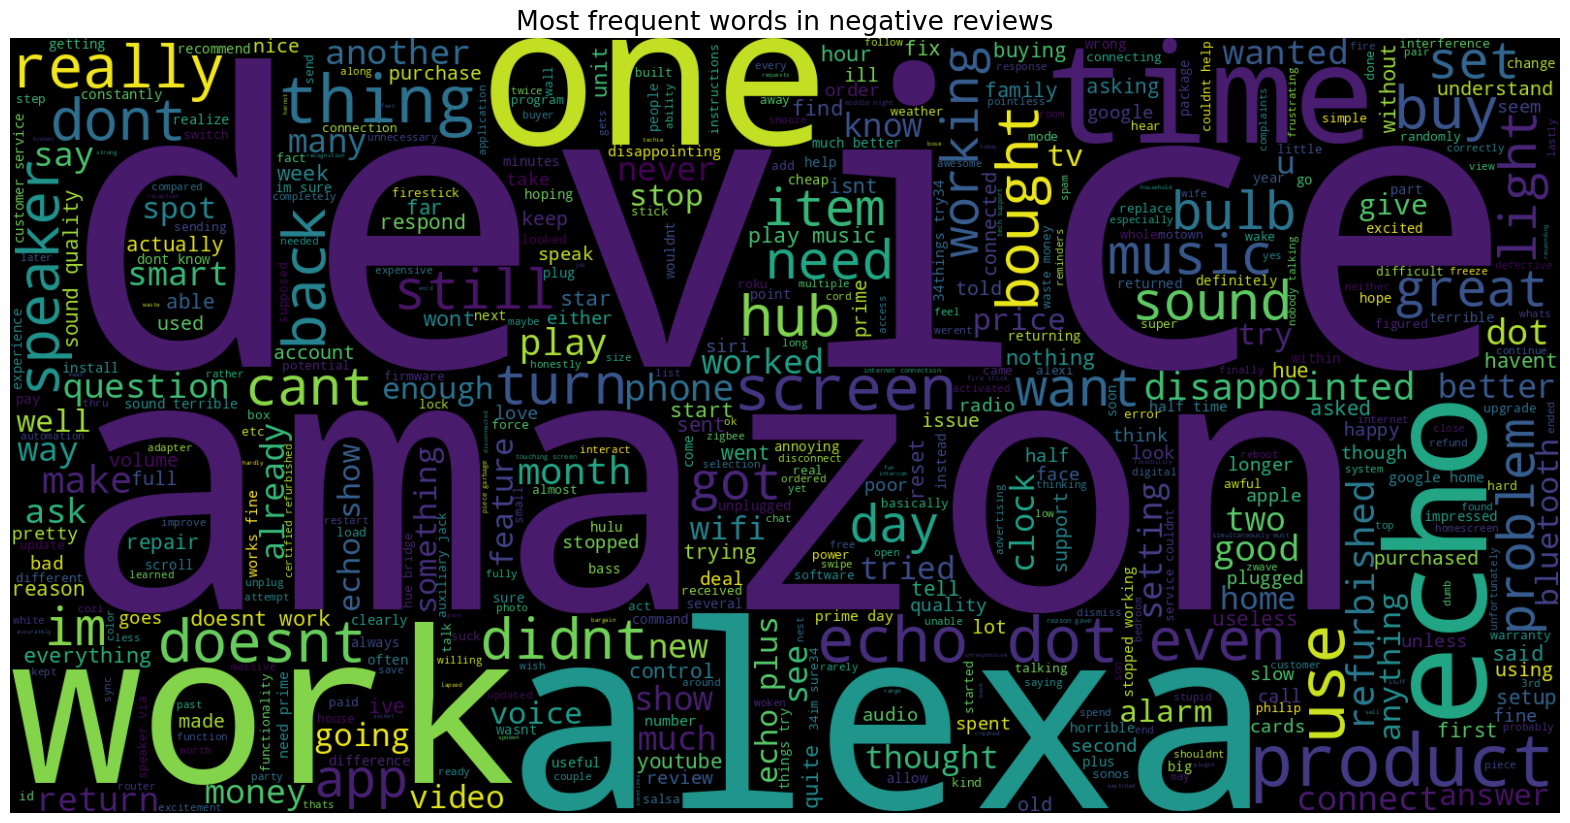

In [11]:
for feedback, title in [(1, 'positive'), (0, 'negative')]:
    reviews = df[df['feedback'] == feedback]
    text = ' '.join([word for word in reviews['verified_reviews']])
    plt.figure(figsize=(20, 15), facecolor=None)
    wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most frequent words in {title} reviews', fontsize=19)
    plt.show()
    print('\n\n')

## Model Building and Evaluation

In [12]:
# Split data into training and test sets
x=df['verified_reviews']
y=df['feedback']
cv=CountVectorizer()
x=cv.fit_transform(x)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [15]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

rf_acc = accuracy_score(y_pred, y_test)
print('Test accuracy: {:.2f}%'.format(rf_acc*100))

Test accuracy: 93.81%


In [16]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 21  37]
 [  2 570]]


              precision    recall  f1-score   support

           0       0.91      0.36      0.52        58
           1       0.94      1.00      0.97       572

    accuracy                           0.94       630
   macro avg       0.93      0.68      0.74       630
weighted avg       0.94      0.94      0.93       630

